In [1]:
import os
import time
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow.train import Checkpoint, CheckpointManager
from tensorflow.data import Dataset
from tensorflow.data.experimental import AUTOTUNE
from tensorflow.keras.models import Model
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import Mean
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import TruncatedNormal, RandomNormal
from tensorflow.keras.layers import Input, Dense, Reshape, BatchNormalization, Conv2D, Conv2DTranspose, \
        LeakyReLU, Flatten, SpatialDropout2D, Dropout, MaxPool2D, GlobalAvgPool2D, Concatenate, LayerNormalization

from IPython import display

print(tf.__version__)

2.3.0


In [2]:
BASE_PATH = r'../Dataset/img_align_celeba'
RANDOM_STATE = 7
SHUFFLE_BUFFER = 32_000
IMAGE_SIZE = (192, 160)
BATCH_SIZE = 32
GEN_NOISE_SHAPE = (6, 5, 8)
GEN_LR = 1e-6
GEN_BETA_1 = 0.5
DISC_LR = 1e-5
DISC_BETA_1 = 0.7
GEN_RELU_ALPHA = 0.2
DISC_RELU_ALPHA = 0.3
PREDICT_COUNT = 9
EPOCHS = 10
DISC_LABEL_SMOOTHING = 0.3
PLOTS_DPI = 150
RETRAIN = True

In [3]:
%%time

image_names = Dataset.list_files(os.path.join(BASE_PATH, '*.jpg'), seed = RANDOM_STATE)
image_count = image_names.cardinality().numpy()
print(f"\nTotal number of image files: {image_count}\n")


Total number of image files: 202599

Wall time: 6.79 s


In [4]:
def load_image_data(filename):
    img = tf.io.read_file(filename)
    img = tf.io.decode_jpeg(img, channels = 3)
    img = tf.image.resize(img, IMAGE_SIZE)
    return (img - 127.5)/127.5

train_ds = image_names.cache() \
        .shuffle(SHUFFLE_BUFFER, seed = RANDOM_STATE) \
        .map(load_image_data, num_parallel_calls = AUTOTUNE) \
        .batch(BATCH_SIZE, drop_remainder = True) \
        .prefetch(buffer_size = AUTOTUNE)

train_ds

<PrefetchDataset shapes: (32, 192, 160, 3), types: tf.float32>

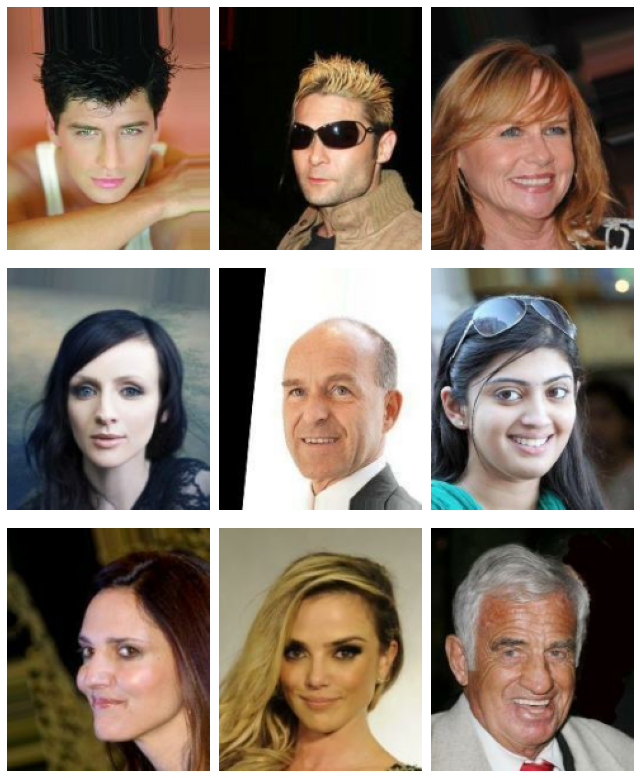

In [5]:
fig, axes = plt.subplots(nrows = 3, ncols = 3, figsize = (9, 11))

sample_images = [i for i in train_ds.take(1)][0].numpy()

for i, ax in enumerate(axes.flatten()):
    ax.imshow((sample_images[i] * 0.5) + 0.5)
    ax.axis(False)
    ax.grid(False)

plt.tight_layout()

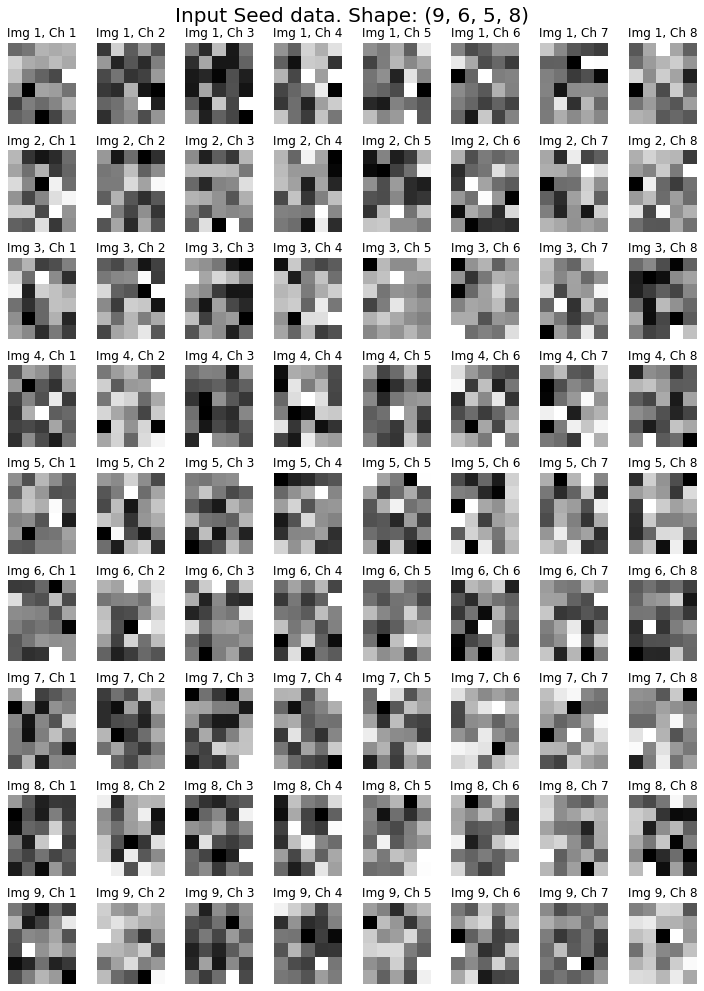

In [6]:
seed_noise = tf.random.normal([PREDICT_COUNT, *GEN_NOISE_SHAPE])

fig, axes = plt.subplots(nrows = PREDICT_COUNT, ncols = GEN_NOISE_SHAPE[2], figsize = (10, 14))

for i in range(PREDICT_COUNT):
    for j in range(GEN_NOISE_SHAPE[2]):
        axes[i][j].imshow(seed_noise[i, :, :, j], cmap = 'gray')
        axes[i][j].axis(False)
        axes[i][j].grid(False)
        axes[i][j].set_title(f"Img {i + 1}, Ch {j + 1}")
        
plt.suptitle(f'Input Seed data. Shape: {seed_noise.shape}', fontsize = 20)
plt.tight_layout()

In [7]:
def generator_model():
    weight_init = TruncatedNormal(mean = 0.0, stddev = 0.02)

    input_layer = Input(shape = GEN_NOISE_SHAPE, name = 'Gen_Input')
    flatten = Flatten(name = 'Gen_Flatten')(input_layer)
    dense = Dense(6 * 5 * 512, activation = LeakyReLU(GEN_RELU_ALPHA), name = 'Gen_Dense')(flatten)
    reshape = Reshape((6, 5, 512), name = 'Gen_Reshape')(dense)
    point_conv = Conv2D(512, 1, padding = 'same', activation = LeakyReLU(GEN_RELU_ALPHA), name = 'Gen_Point_Conv')(reshape)

    conv_T_1 = Conv2DTranspose(256, (3, 3), padding = 'same', activation = LeakyReLU(GEN_RELU_ALPHA),
                               kernel_initializer = weight_init, name = 'Gen_Conv_T_1')(point_conv)    
    sp_dropout_1 = SpatialDropout2D(0.1, name = 'Gen_SD_1')(conv_T_1)
    

    conv_T_2 = Conv2DTranspose(128, (3, 3), padding = 'same', strides = (2, 2),
                               kernel_initializer = weight_init, name = 'Gen_Conv_T_2')(sp_dropout_1)
    bn_1 = BatchNormalization(name = 'Gen_BN_1')(conv_T_2)
    lr_1 = LeakyReLU(GEN_RELU_ALPHA, name = 'Gen_LR_1')(bn_1)
    conv_T_3 = Conv2DTranspose(64, (3, 3), padding = 'same', strides = (2, 2), activation = LeakyReLU(GEN_RELU_ALPHA),
                               kernel_initializer = weight_init, name = 'Gen_Conv_T_3')(lr_1)
    

    conv_T_4 = Conv2DTranspose(64, (4, 4), padding = 'same', activation = LeakyReLU(GEN_RELU_ALPHA),
                               kernel_initializer = weight_init, name = 'Gen_Conv_T_4')(conv_T_3)    
    sp_dropout_2 = SpatialDropout2D(0.1, name = 'Gen_SD_2')(conv_T_4)


    conv_T_5 = Conv2DTranspose(32, (4, 4), padding = 'same', strides = (2, 2), activation = LeakyReLU(GEN_RELU_ALPHA),
                               kernel_initializer = weight_init, name = 'Gen_Conv_T_5')(sp_dropout_2)
    bn_2 = BatchNormalization(name = 'Gen_BN_2')(conv_T_5)
    lr_2 = LeakyReLU(GEN_RELU_ALPHA, name = 'Gen_LR_2')(bn_2)
    conv_T_6 = Conv2DTranspose(16, (4, 4), padding = 'same', strides = (2, 2), activation = LeakyReLU(GEN_RELU_ALPHA),
                                kernel_initializer = weight_init, name = 'Gen_Conv_T_6')(lr_2)
    

    conv_T_7 = Conv2DTranspose(16, (5, 5), padding = 'same', activation = LeakyReLU(GEN_RELU_ALPHA), strides = (2, 2),
                               kernel_initializer = weight_init, name = 'Gen_Conv_T_7')(conv_T_6)    
    

    conv_T_8 = Conv2DTranspose(3, (5, 5), padding = 'same',
                               activation = 'tanh', name = 'Gen_Conv_T_8')(conv_T_7)
    
    return Model(inputs = input_layer, outputs = conv_T_8, name = 'Generator')
    
generator = generator_model()
generator.summary()

Model: "Generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Gen_Input (InputLayer)       [(None, 6, 5, 8)]         0         
_________________________________________________________________
Gen_Flatten (Flatten)        (None, 240)               0         
_________________________________________________________________
Gen_Dense (Dense)            (None, 15360)             3701760   
_________________________________________________________________
Gen_Reshape (Reshape)        (None, 6, 5, 512)         0         
_________________________________________________________________
Gen_Point_Conv (Conv2D)      (None, 6, 5, 512)         262656    
_________________________________________________________________
Gen_Conv_T_1 (Conv2DTranspos (None, 6, 5, 256)         1179904   
_________________________________________________________________
Gen_SD_1 (SpatialDropout2D)  (None, 6, 5, 256)         0 

In [8]:
def discriminator_model():
    input_layer = Input(shape = (*IMAGE_SIZE, 3), name = 'Disc_Input')
    
    conv_1 = Conv2D(32, (4, 4), activation = LeakyReLU(DISC_RELU_ALPHA), padding = 'same', name = 'Disc_Conv_1')(input_layer)
    max_pool_1 = MaxPool2D(2, name = 'Disc_MP_1')(conv_1)
    conv_2 = Conv2D(64, (4, 4), activation = LeakyReLU(DISC_RELU_ALPHA), padding = 'same', name = 'Disc_Conv_2')(max_pool_1)
    max_pool_2 = MaxPool2D(2, name = 'Disc_MP_2')(conv_2)
    global_pool_1 = GlobalAvgPool2D(name = 'Disc_GAP_1')(max_pool_2)
    
    sp_dropout_1 = SpatialDropout2D(0.2, name = 'Disc_SD_1')(max_pool_2)
    conv_3 = Conv2D(128, (3, 3), activation = LeakyReLU(DISC_RELU_ALPHA), padding = 'same', name = 'Disc_Conv_3')(sp_dropout_1)
    max_pool_3 = MaxPool2D(2, name = 'Disc_MP_3')(conv_3)
    conv_4 = Conv2D(256, (3, 3), activation = LeakyReLU(DISC_RELU_ALPHA), padding = 'same', name = 'Disc_Conv_4')(max_pool_3)
    max_pool_4 = MaxPool2D(2, name = 'Disc_MP_4')(conv_4)
    global_pool_2 = GlobalAvgPool2D(name = 'Disc_GAP_2')(max_pool_4)
    
    sp_dropout_2 = SpatialDropout2D(0.2, name = 'Disc_SD_2')(max_pool_4)
    conv_5 = Conv2D(512, (2, 2), activation = LeakyReLU(DISC_RELU_ALPHA), padding = 'same', name = 'Disc_Conv_5')(sp_dropout_2)
    max_pool_5 = MaxPool2D(2, name = 'Disc_MP_5')(conv_5)
    global_pool_3 = GlobalAvgPool2D(name = 'Disc_GAP_3')(max_pool_5)
    
    concat = Concatenate(name = 'Disc_Concat')([global_pool_1, global_pool_2, global_pool_3])
    dropout = Dropout(0.2, name = 'Disc_Dropout')(concat)
    dense_1 = Dense(64, activation = LeakyReLU(DISC_RELU_ALPHA), name = 'Disc_Dense_1')(dropout)
    dense_2 = Dense(16, name = 'Disc_Dense_2')(dense_1)
    dense_3 = Dense(1, name = 'Disc_Dense_3')(dense_2)
    
    return Model(inputs = input_layer, outputs = dense_3, name = 'Discriminator')
    
discriminator = discriminator_model()
discriminator.summary()

Model: "Discriminator"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Disc_Input (InputLayer)         [(None, 192, 160, 3) 0                                            
__________________________________________________________________________________________________
Disc_Conv_1 (Conv2D)            (None, 192, 160, 32) 1568        Disc_Input[0][0]                 
__________________________________________________________________________________________________
Disc_MP_1 (MaxPooling2D)        (None, 96, 80, 32)   0           Disc_Conv_1[0][0]                
__________________________________________________________________________________________________
Disc_Conv_2 (Conv2D)            (None, 96, 80, 64)   32832       Disc_MP_1[0][0]                  
______________________________________________________________________________________

In [9]:
cross_entropy = BinaryCrossentropy(from_logits = True)
gen_mean_loss = Mean(name = "Generator mean loss")
disc_mean_loss = Mean(name = "Discriminator mean loss")
generator_optimizer = Adam(GEN_LR, beta_1 = GEN_BETA_1)
discriminator_optimizer = Adam(DISC_LR, beta_1 = DISC_BETA_1)

In [10]:
checkpoint_dir = './ckpt'

checkpoint = Checkpoint(
    step = tf.Variable(1),
    generator_optimizer = generator_optimizer,
    discriminator_optimizer = discriminator_optimizer,
    generator = generator,
    discriminator = discriminator)

ckpt_manager = CheckpointManager(checkpoint, checkpoint_dir, max_to_keep = 4)

EPOCH_START = 1
if RETRAIN:
    checkpoint.restore(ckpt_manager.latest_checkpoint)
    EPOCH_START = checkpoint.step.numpy()

print(f"Starting training from Epoch {EPOCH_START}")

Starting training from Epoch 31


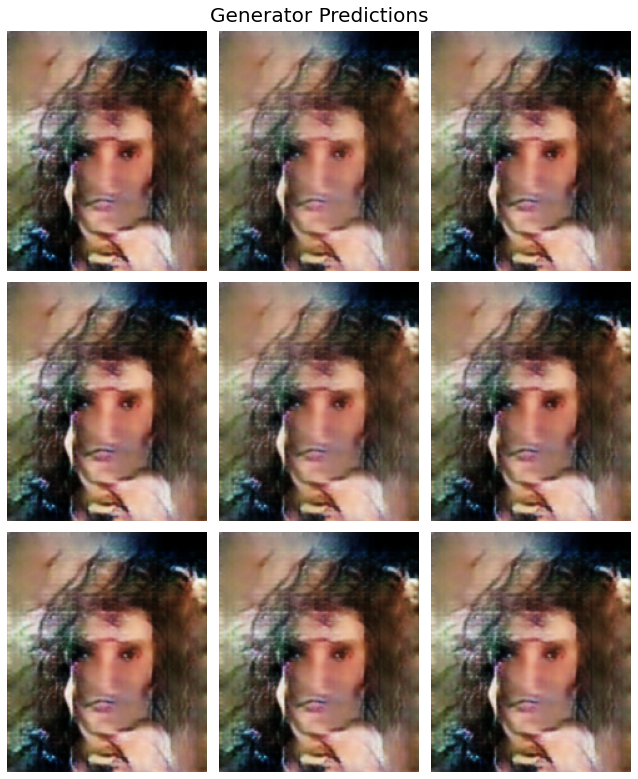

In [11]:
def generate_images(seed, save = False, epoch = None):
    pred = generator(seed, training = False)

    fig, axes = plt.subplots(nrows = 3, ncols = 3, figsize = (9, 11))

    for i, ax in enumerate(axes.flatten()):
        ax.imshow((pred[i] * 0.5) + 0.5)
        ax.axis(False)
        ax.grid(False)

    plt.suptitle('Generator Predictions', fontsize = 20)
    
    plt.tight_layout()

    if save:
        plt.savefig(f'Outputs/Pred_Epoch_{epoch:04d}.png', dpi = PLOTS_DPI, facecolor = 'white', 
                transparent = False, bbox_inches = 'tight')
        plt.close()
    
generate_images(seed_noise)

In [12]:
discriminator(generator(seed_noise, training = False), training = False).numpy()

array([[-1.6057177],
       [-1.6233464],
       [-1.6217175],
       [-1.600211 ],
       [-1.6201202],
       [-1.6316844],
       [-1.6099906],
       [-1.6266056],
       [-1.6051195]], dtype=float32)

In [13]:
def discriminator_loss(real_output, fake_output):
    pos_labels = tf.ones_like(real_output) - (tf.random.uniform(real_output.shape) * DISC_LABEL_SMOOTHING)
    neg_labels = tf.zeros_like(fake_output) + (tf.random.uniform(fake_output.shape) * DISC_LABEL_SMOOTHING)
    real_loss = cross_entropy(pos_labels, real_output)
    fake_loss = cross_entropy(neg_labels, fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [14]:
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, *GEN_NOISE_SHAPE])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training = True)

        real_output = discriminator(images, training = True)
        fake_output = discriminator(generated_images, training = True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gen_mean_loss(gen_loss)
    disc_mean_loss(disc_loss)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [15]:
gen_losses = []
disc_losses = []

def train(dataset, epochs):
    for epoch in range(EPOCHS):
        start = time.time()

        gen_mean_loss.reset_states()
        disc_mean_loss.reset_states()
        
        print(f"\nTraining Epoch {epoch + EPOCH_START}\n")
        
        for batch_ind, image_batch in enumerate(dataset):
            train_step(image_batch)

            if (batch_ind + 1) % 10 == 0:
                print(". ", end = '')
            if (batch_ind + 1) % 250 == 0:
                print(f"{batch_ind + 1}")
        
        checkpoint.step.assign_add(1)

        display.clear_output(wait = True)
        
        generate_images(seed_noise, True, epoch + EPOCH_START)

        if (epoch + EPOCH_START) % 5 == 0:
            ckpt_manager.save()
            
        gen_losses.append(gen_mean_loss.result())
        disc_losses.append(disc_mean_loss.result())

        print(f"\nEpoch: {epoch + EPOCH_START}\n")
        print(f'Generator Loss: {gen_mean_loss.result():.4f}')
        print(f'Discriminator Loss: {disc_mean_loss.result():.4f}')
        print (f'Time elapsed: {time.time() - start:.2f} s')

    display.clear_output(wait = True)

In [16]:
%%time

train(train_ds, EPOCHS)

print(f'Final Generator Loss: {gen_mean_loss.result()}')
print(f'Final Discriminator Loss: {disc_mean_loss.result()}')

Final Generator Loss: 1.8933086395263672
Final Discriminator Loss: 0.8470858931541443
Wall time: 5h 20min 40s


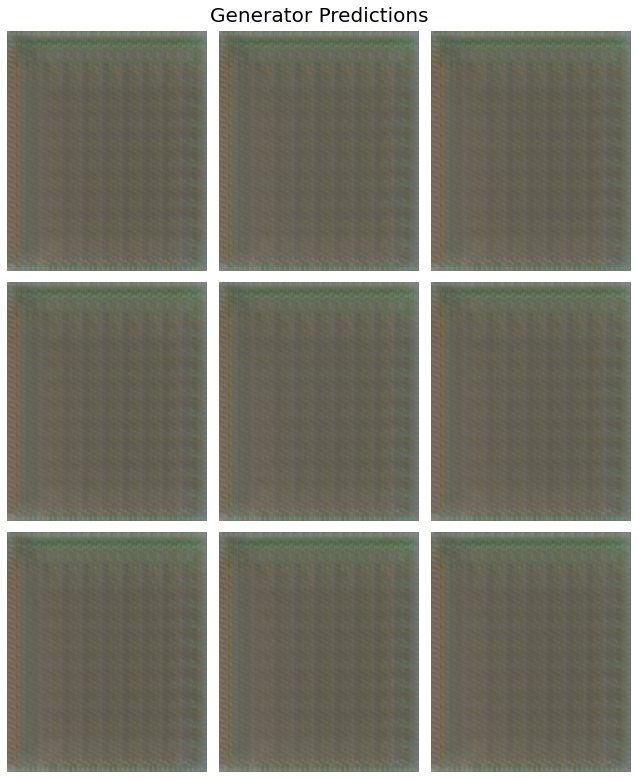

In [17]:
generate_images(seed_noise)

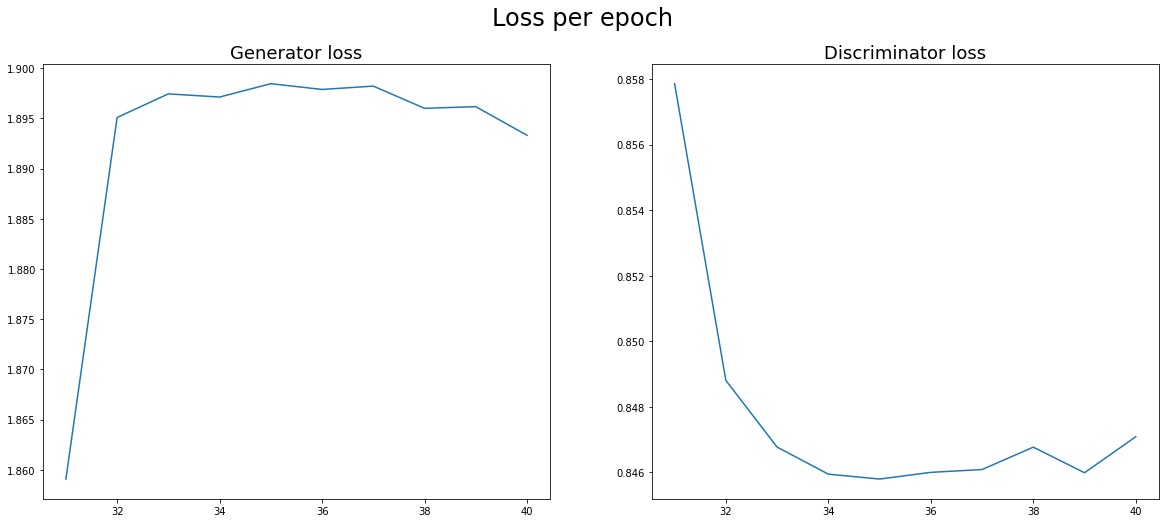

In [18]:
epoch_range = range(EPOCH_START, EPOCHS + EPOCH_START)
plt.figure(figsize = (20, 8))

plt.subplot(1, 2, 1)
plt.plot(epoch_range, gen_losses)
plt.title('Generator loss', fontsize = 18)

plt.subplot(1, 2, 2)
plt.plot(epoch_range, disc_losses)
plt.title('Discriminator loss', fontsize = 18)

plt.suptitle('Loss per epoch', fontsize = 24)
plt.show()

In [19]:
generator.save("generator")
discriminator.save("discriminator")

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: generator\assets
INFO:tensorflow:Assets written to: discriminator\assets
